# Kaokore Facial Verification
> Matching friendly faces with ancient japanese painting, by way of deep neural image embedding and K-nearest-neighbor decoding.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

<img src="./images_kaokore/dataset_example.png" />

# Overview

The recent Kaokore (https://arxiv.org/abs/2002.08595) facial dataset presents some exciting creative opportunities for machine learning on these images. We have nearly 9,000 faces, each associated with a ``male`` or ``female`` gender label as well as a social status label (one of ``Noble, Warrior, Incarnation,`` or ``Commoner``).

## Approach

I've built a quick ResNet18 pipeline. No training here and this is totally unsupervised (for now!). Rather, I simply embed each painting into a vector $\vec{v}$ of cardinality 1,000. Then, these vectors are fitted to a k-nearest-neighbors ($k=5$ for now) estimator from ```scikit-learn```. Finally, I embed my some human faces (including my own) as queries to this estimator, then retrieve the indices of the k-most-similar vectors. The results are pretty rough, and my plan is to fine-tune FaceNet or another more niche network on these data. Another possibility is a more recent self-supervised model trained with Contrastive Predictive Coding (CPC).


<img src="./images_kaokore/label_example.png" />

In [4]:
%matplotlib inline

from IPython.display import Image
from IPython.display import display

import joblib
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import torch
from torch.autograd import Variable
from PIL import Image
from torchvision.utils import make_grid
from IPython.display import Image
from IPython.display import display
import torchvision
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
!git clone https://github.com/rois-codh/kaokore

Cloning into 'kaokore'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 85 (delta 33), reused 39 (delta 7), pack-reused 0
Unpacking objects: 100% (85/85), done.


In [ ]:
!cd kaokore && python3 download.py --dataset_version 1.2

 36% 3179/8848 [02:14<01:51, 50.83it/s]Grayscale -> RGB : kaokore/images_256/00003184.jpg
 36% 3185/8848 [02:14<01:54, 49.55it/s]Grayscale -> RGB : kaokore/images_256/00003185.jpg
Grayscale -> RGB : kaokore/images_256/00003186.jpg
Grayscale -> RGB : kaokore/images_256/00003188.jpg
Grayscale -> RGB : kaokore/images_256/00003190.jpg
Grayscale -> RGB : kaokore/images_256/00003191.jpg
Grayscale -> RGB : kaokore/images_256/00003192.jpg
 36% 3191/8848 [02:14<02:04, 45.41it/s]Grayscale -> RGB : kaokore/images_256/00003193.jpg
Grayscale -> RGB : kaokore/images_256/00003194.jpg
Grayscale -> RGB : kaokore/images_256/00003187.jpg
Grayscale -> RGB : kaokore/images_256/00003195.jpg
Grayscale -> RGB : kaokore/images_256/00003189.jpg
 36% 3196/8848 [02:15<02:05, 44.94it/s]Grayscale -> RGB : kaokore/images_256/00003196.jpg
Grayscale -> RGB : kaokore/images_256/00003197.jpg
Grayscale -> RGB : kaokore/images_256/00003198.jpg
Grayscale -> RGB : kaokore/images_256/00003200.jpg
 36% 3202/8848 [02:15<02:07,

In [5]:
class Embedder:
    def __init__(self):
        self.image_embeddings=[]
        self.model = models.resnet18(pretrained=True).to(DEVICE)
        self.imsize=256

    def load_images(self):
        self.dataset = ImageFolder(root='./kaokore',transform=torchvision.transforms.ToTensor())
        self.loader = DataLoader(self.dataset)

    def embed_images(self):
        for x,_ in tqdm(self.loader):
            x = x.to(DEVICE)
            fx = self.model(x)
            self.image_embeddings.append(fx.detach().cpu().numpy().flatten())

    def generate_estimator(self):#,model_fname):
        knn_estimator = NearestNeighbors(n_neighbors=5, metric="cosine")
        knn_estimator.fit(np.array(self.image_embeddings))
        # save the model to disk ?
        # joblib.dump(knn_estimator, model_fname)
        return knn_estimator


    def embed_single_image(self,image_fpath):
        """load image, returns cuda tensor"""

        loader = transforms.Compose([transforms.Scale(self.imsize), transforms.ToTensor()])
        image = Image.open(image_fpath)
        image = loader(image).float()
        image = Variable(image, requires_grad=True)
        image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
        image = image.to(DEVICE)
        embedding = self.model(image).detach().cpu().numpy().flatten()
        return embedding

    def query_knn(self, query_embedding):
        _, top_indices = self.estimator.kneighbors([query_embedding]) # find k nearest train neighbours
        top_indices=top_indices.flatten()
        return top_indices


In [6]:
# model_fname = './fitted_knn_kaokore.pkl'    
# Fit kNN model on embedded images
k = 5
image_embedder = Embedder()
print('Loading images...')
image_embedder.load_images()
print('Embedding Kaokore paintings with a neural network...')
image_embedder.embed_images()

Loading images...
Embedding Kaokore paintings with a neural network...


In [11]:
  print(f'Fitting and saving {k}-nearest-neighbour model on image embeddings...')
  knn=image_embedder.generate_estimator()

Fitting and saving 5-nearest-neighbour model on image embeddings...


In [12]:
knn

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [13]:
test1='/content/63212182948__89FADCD6-CDD0-4821-A046-9C3237E9732B.jpeg'
test2='/content/63212325784__F25E76D5-9E72-408A-9256-2BFE5A7E4895.jpeg'
test3='/content/test.jpg'

images_dataset = ImageFolder(root='./kaokore')

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

results=[]
test_img_fpaths = [test1,test2,test3]

# inferrer = Inference(image_embedder)

for img in test_img_fpaths:
  print(img)
  test_embedding= image_embedder.embed_single_image(img)
  _,top_k_indices = knn.kneighbors([test_embedding])
  top_k_indices=top_k_indices.flatten()
  # top_k_indices = image_embedder.query_knn(test_embedding)
  print(f'top {k} indices found were \n\n{top_k_indices}')
  print('Saving a grid of these images...')
  results.append(top_k_indices)

/content/63212182948__89FADCD6-CDD0-4821-A046-9C3237E9732B.jpeg
top 5 indices found were 

[5891 6531 3822 7168 2401]
Saving a grid of these images...
/content/63212325784__F25E76D5-9E72-408A-9256-2BFE5A7E4895.jpeg


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


top 5 indices found were 

[7182 6006  139 5121 4420]
Saving a grid of these images...
/content/test.jpg
top 5 indices found were 

[6648 2944 1457 2391 6892]
Saving a grid of these images...


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [41]:
from IPython.display import display, Image

img_list1 = [images_dataset[i][0] for i in results[0]]
img_list2 = [images_dataset[i][0] for i in results[1]]
img_list3 = [images_dataset[i][0] for i in results[2]]

Now, let's see what paintings match a picture of me...

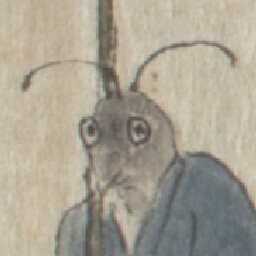

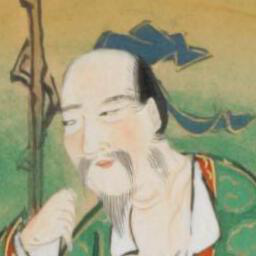

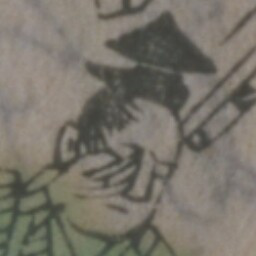

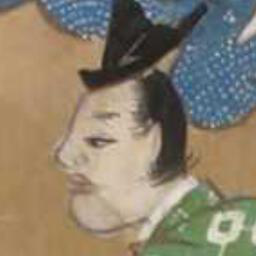

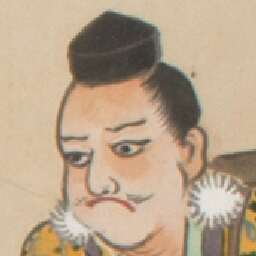

In [30]:
display(*img_list3)

## Work in progress...

I hope to fine-tune a triplet-loss or self-supervised model on the paintings at some point. This should result in better matches. Stay tuned!